In [1]:
import os 
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from scipy.stats import mannwhitneyu

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

# Visualization of the invasive cancer clusters

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
def normalized_cluster_entropy(counts: pd.Series, n_clusters: int) -> float:
    """Return entropy-based dispersion score in [0, 1] for cluster counts."""
    probs = counts.values / counts.values.sum()
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    max_entropy = log(n_clusters) if n_clusters > 1 else 1.0
    return float(entropy / max_entropy) if max_entropy > 0 else 0.0

In [4]:
patient_cluster_stats = []

for model_type, names, benchmark_path in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']],
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    invasive_path = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
    optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)

    for name in names:
        if name == "uni" and benchmark_path == config['retrained_benchmark_folder2']:
            continue
        filename = glob.glob(os.path.join(invasive_path, name, f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
        
        df = pd.read_csv(filename, index_col=0)
        df["patient"] = df.index.str.split("_").str[0]
        df["type"] = ["spot" if "spot" in idx else "patch" for idx in df.index]
        patient_with_low_invasive_cancer = df.value_counts("patient")[df.value_counts("patient") < 100].index.tolist()
        df = df[~df["patient"].isin(patient_with_low_invasive_cancer)]
        df = df[df["type"] == "spot"]

        n_global_clusters = df["predicted_label"].nunique()
        if n_global_clusters == 0:
            raise ValueError("No predicted_label values found in the dataframe after filtering.")

        for patient, group in df.groupby("patient"):
            cluster_counts = group["predicted_label"].value_counts()
            cluster_prop = cluster_counts/cluster_counts.sum()
            cluster_prop_dict = {k: v for k, v in zip(cluster_prop.index, cluster_prop.values)}
            for i in range(n_global_clusters):
                if i not in cluster_prop_dict.keys():
                    cluster_prop_dict[i] = 0

            cluster_prop_dict = dict(sorted(cluster_prop_dict.items()))
            diversity_score = normalized_cluster_entropy(cluster_counts, n_global_clusters)
            patient_cluster_stats.append({
                "patient": patient,
                "cluster_diversity_score": diversity_score,
                "n_clusters_present": int(cluster_counts.size),
                "dominant_cluster": cluster_counts.idxmax(),
                "model": name,
                "proportions": cluster_prop_dict,
            })

cluster_repartition_df = pd.DataFrame(patient_cluster_stats).sort_values("cluster_diversity_score", ascending=False)
cluster_repartition_df

,patient,cluster_diversity_score,n_clusters_present,dominant_cluster,model,proportions
774,TNBC49,8.628282e-01,5,1,uni_full_koleo_16384_prototypes,"{0: 0.21951219512195122, 1: 0.2439024390243902..."
582,TNBC49,8.313248e-01,5,2,uni_full_kde_16384_prototypes,"{0: 0.24175824175824176, 1: 0.1318681318681318..."
795,TNBC78,8.195722e-01,6,1,uni_full_koleo_16384_prototypes,"{0: 0.009009009009009009, 1: 0.297297297297297..."
357,TNBC20,8.113438e-01,4,0,uni_explora_koleo_16384_prototypes,"{0: 0.4035947712418301, 1: 0.00816993464052287..."
858,TNBC78,8.056135e-01,5,0,uni_full_koleo_65536_prototypes,"{0: 0.3848314606741573, 1: 0.19382022471910113..."
...,...,...,...,...,...,...
513,TNBC44,-7.214116e-13,1,0,uni_full_kde_4096_prototypes,"{0: 1.0, 1: 0, 2: 0, 3: 0}"
520,TNBC53,-7.214116e-13,1,1,uni_full_kde_4096_prototypes,"{0: 0, 1: 1.0, 2: 0, 3: 0}"
395,TNBC66,-7.214116e-13,1,0,uni_explora_koleo_16384_prototypes,"{0: 1.0, 1: 0, 2: 0, 3: 0}"
313,TNBC53,-7.214116e-13,1,0,uni_explora_koleo_4096_prototypes,"{0: 1.0, 1: 0, 2: 0, 3: 0}"


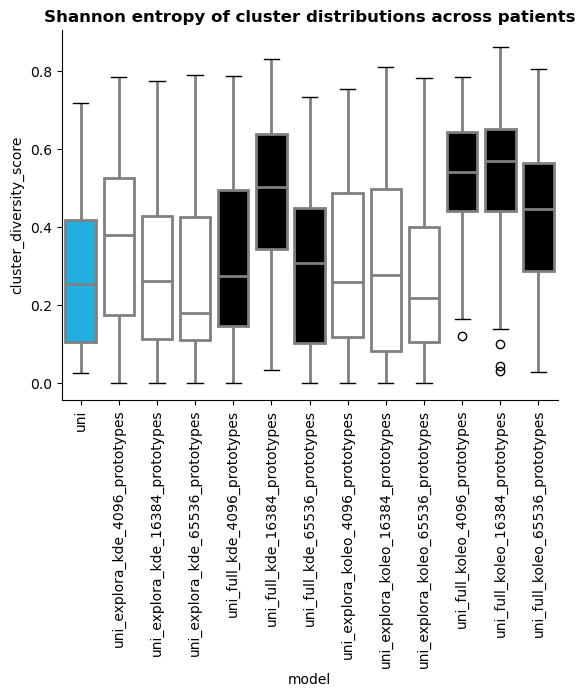

In [5]:
retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

# Order models according to sorted_retrained_models, keep any extra models at the end
model_order = [m for m in sorted_retrained_models if m in cluster_repartition_df['model'].unique()]
extra_models = [m for m in cluster_repartition_df['model'].unique() if m not in model_order]
categories = model_order + extra_models
cluster_repartition_df['model'] = pd.Categorical(cluster_repartition_df['model'], categories=categories, ordered=True)
cluster_repartition_df = cluster_repartition_df.sort_values('model').reset_index(drop=True)

palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

sns.boxplot(
    data=cluster_repartition_df, x='model', y="cluster_diversity_score", hue="model", palette=palette, 
    boxprops=dict(edgecolor='gray', linewidth=2), medianprops=dict(color='gray', linewidth=2), 
    whiskerprops=dict(color='gray', linewidth=2))

plt.xticks(rotation=90)
sns.despine()
plt.title("Shannon entropy of cluster distributions across patients", weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"cluster_diversity_in_retrained_models.pdf"), bbox_inches='tight')

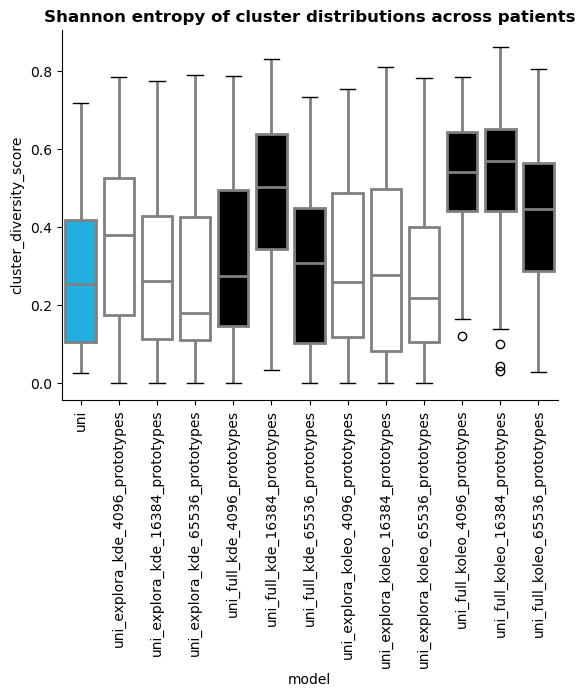

In [6]:
sns.boxplot(
    data=cluster_repartition_df, y="cluster_diversity_score", x='model', hue="model", palette=palette, 
    boxprops=dict(edgecolor='gray', linewidth=2), medianprops=dict(color='gray', linewidth=2),
    whiskerprops=dict(color='gray', linewidth=2))

plt.xticks(rotation=90)
sns.despine()
plt.title("Shannon entropy of cluster distributions across patients", weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"cluster_diversity_in_retrained_models.pdf"), bbox_inches='tight')

## Hexagon Simplex

In [7]:
def create_simplex_plot(model_name, cluster_repartition_df, palette):
    """
    Create a simplex plot for a given model.
    Automatically adapts to the number of clusters (triangle, square, pentagon, hexagon, etc.)
    """
    # Filter for the specified model
    df_model = cluster_repartition_df[cluster_repartition_df['model'] == model_name].copy()
    
    if len(df_model) == 0:
        print(f"No data found for model: {model_name}")
        return None
    
    # Get number of clusters from the data
    n_clusters = len(df_model.iloc[0]['proportions'])
    n_patients = len(df_model)
    
    print(f"\nModel: {model_name}")
    print(f"Number of patients: {n_patients}")
    print(f"Number of clusters: {n_clusters}")
    
    # Define polygon vertices (n_clusters points equally spaced around a circle)
    # Start at top (90 degrees) and go clockwise
    angles = np.linspace(90, 90 - 360, n_clusters, endpoint=False) * np.pi / 180
    polygon_vertices = np.array([[np.cos(angle), np.sin(angle)] for angle in angles])
    
    # Convert cluster proportions to 2D coordinates using barycentric positioning
    patient_coords = []
    
    for _, row in df_model.iterrows():
        prop_dict = row['proportions']
        
        # Extract proportion weights for each cluster
        weights = np.array([prop_dict.get(i, 0.0) for i in range(n_clusters)])
        
        # Calculate weighted average of polygon vertices
        x = np.sum(weights * polygon_vertices[:, 0])
        y = np.sum(weights * polygon_vertices[:, 1])
        
        patient_coords.append({
            "patient": row["patient"],
            "x": x,
            "y": y,
            "dominant_cluster": row["dominant_cluster"],
            "cluster_diversity_score": row["cluster_diversity_score"]
        })
    
    df_coords = pd.DataFrame(patient_coords)
    
    # Create the simplex plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw graduation polygons at 0.2, 0.4, 0.6, 0.8 scales (dashed lines)
    for scale in [0.2, 0.4, 0.6, 0.8]:
        scaled_vertices = polygon_vertices * scale
        scaled_vertices_closed = np.vstack([scaled_vertices, scaled_vertices[0]])
        ax.plot(scaled_vertices_closed[:, 0], scaled_vertices_closed[:, 1], 
                'k--', linewidth=1, alpha=0.3, zorder=0)
    
    # Draw center point
    ax.scatter(0, 0, s=50, c='black', marker='+', linewidths=2, zorder=1)
    
    # Draw outer polygon edges (solid line)
    polygon_vertices_closed = np.vstack([polygon_vertices, polygon_vertices[0]])
    ax.plot(polygon_vertices_closed[:, 0], polygon_vertices_closed[:, 1], 
            'k-', linewidth=2, zorder=1)
    
    # Add cluster labels at vertices
    for i, vertex in enumerate(polygon_vertices):
        # Get color from palette, use default if not available
        vertex_color = palette.get(str(i), '#808080')
        
        ax.scatter(vertex[0], vertex[1], s=500, c=vertex_color, 
                  zorder=3, marker='o', edgecolors='black', linewidths=2)
        
        # Offset labels slightly outward
        offset = vertex * 1.15
        ax.text(offset[0], offset[1], f'Cluster {i}', 
                ha='center', va='center', fontsize=14, fontweight='bold', 
                zorder=4, color=vertex_color)
    
    # Plot patients as black points
    ax.scatter(df_coords['x'], df_coords['y'], 
               color='black',
               s=50, 
               alpha=0.6, 
               zorder=2)
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    
    # Determine shape name for title
    shape_names = {2: "Line", 3: "Triangle", 4: "Square", 5: "Pentagon", 
                   6: "Hexagon", 7: "Heptagon", 8: "Octagon"}
    shape_name = shape_names.get(n_clusters, f"{n_clusters}-gon")
    
    ax.set_title(f'{shape_name} Simplex: Patient Cluster Distribution\n({model_name})', 
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    
    sns.despine()
    plt.tight_layout()
    
    # Save figure before showing (showing clears the figure)
    plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"simplex_{model_name}.pdf"), bbox_inches='tight')
    plt.show()
    
    return df_coords


Model: uni
Number of patients: 69
Number of clusters: 5


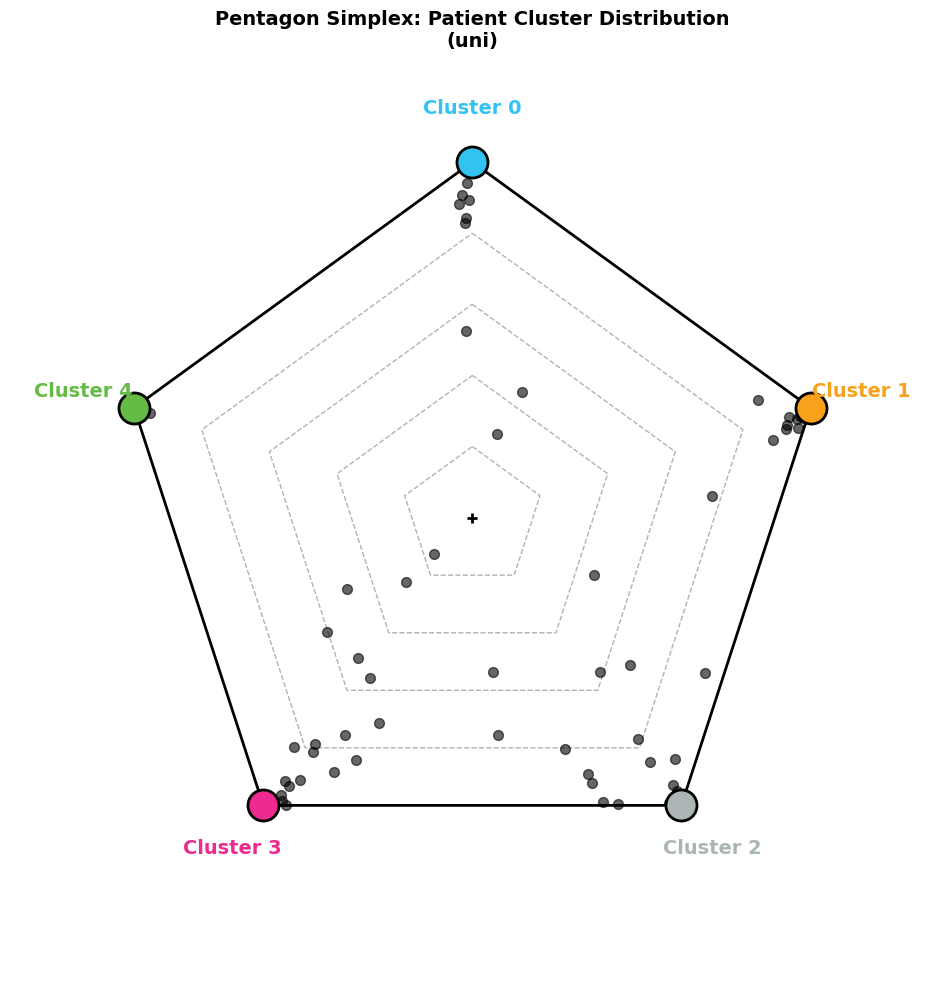


Model: uni_explora_kde_4096_prototypes
Number of patients: 71
Number of clusters: 7


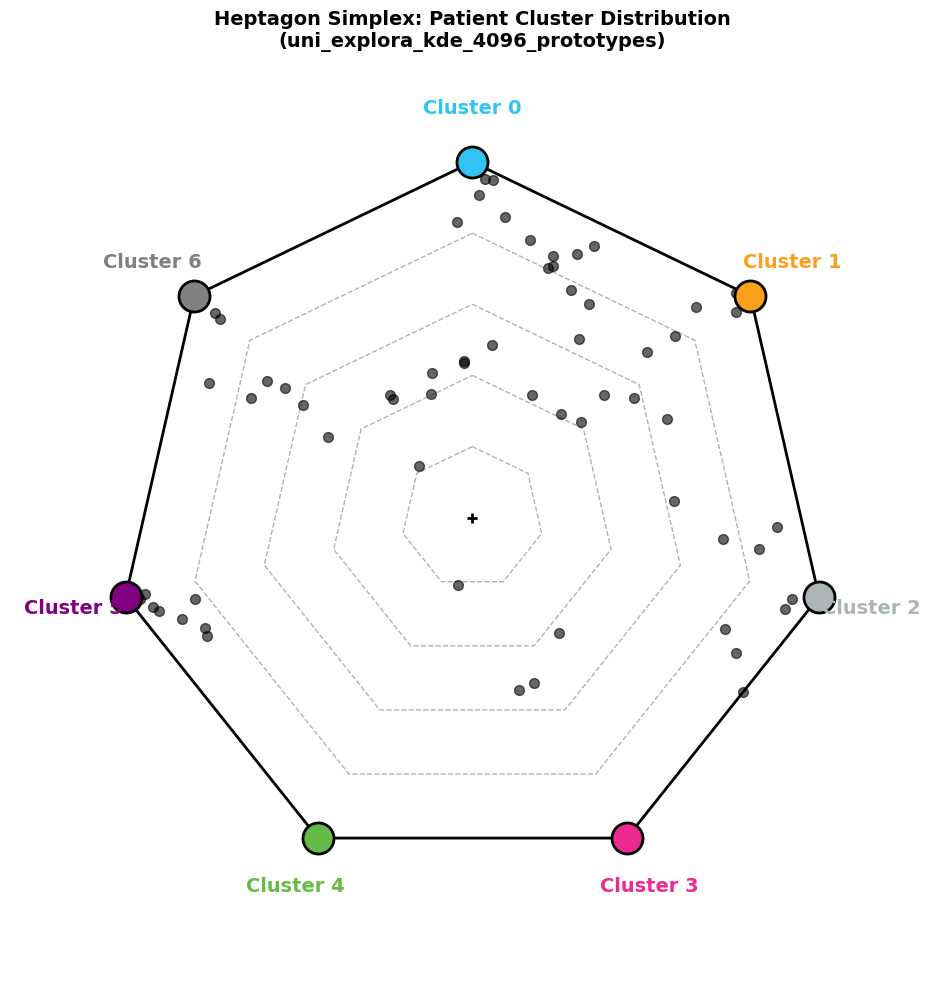


Model: uni_explora_kde_16384_prototypes
Number of patients: 70
Number of clusters: 6


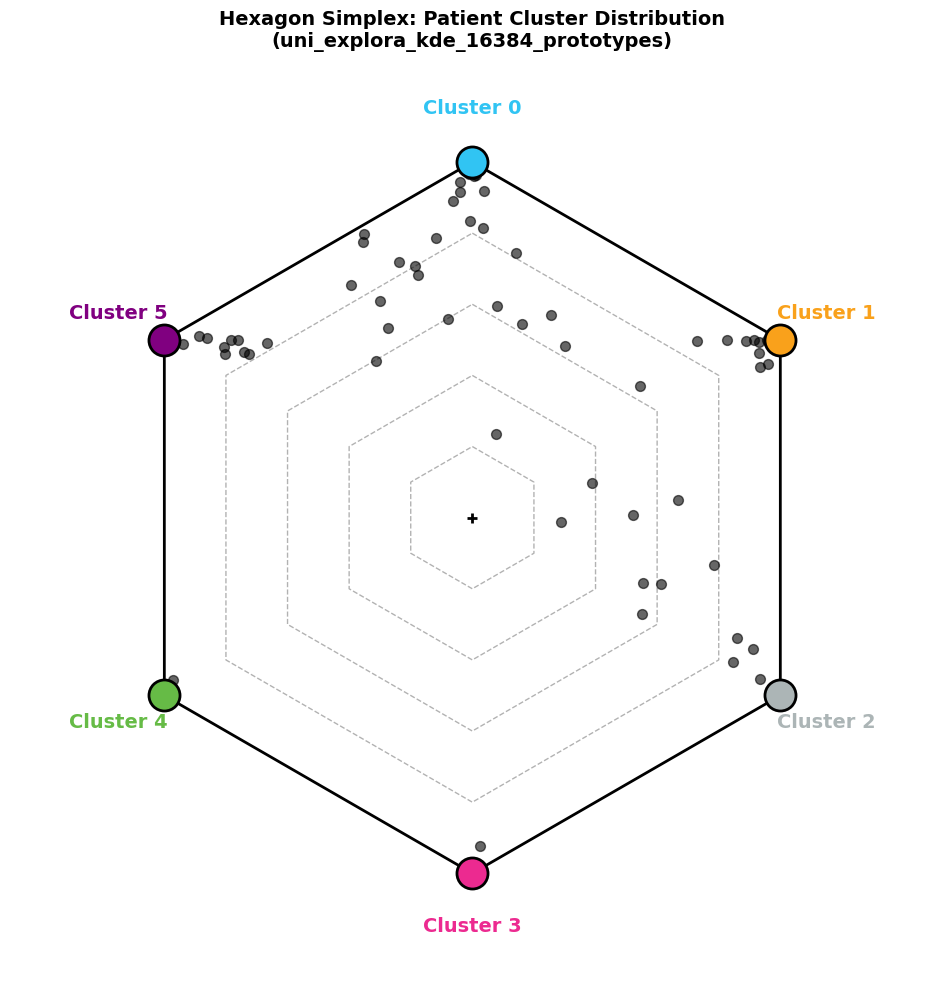


Model: uni_explora_kde_65536_prototypes
Number of patients: 69
Number of clusters: 4


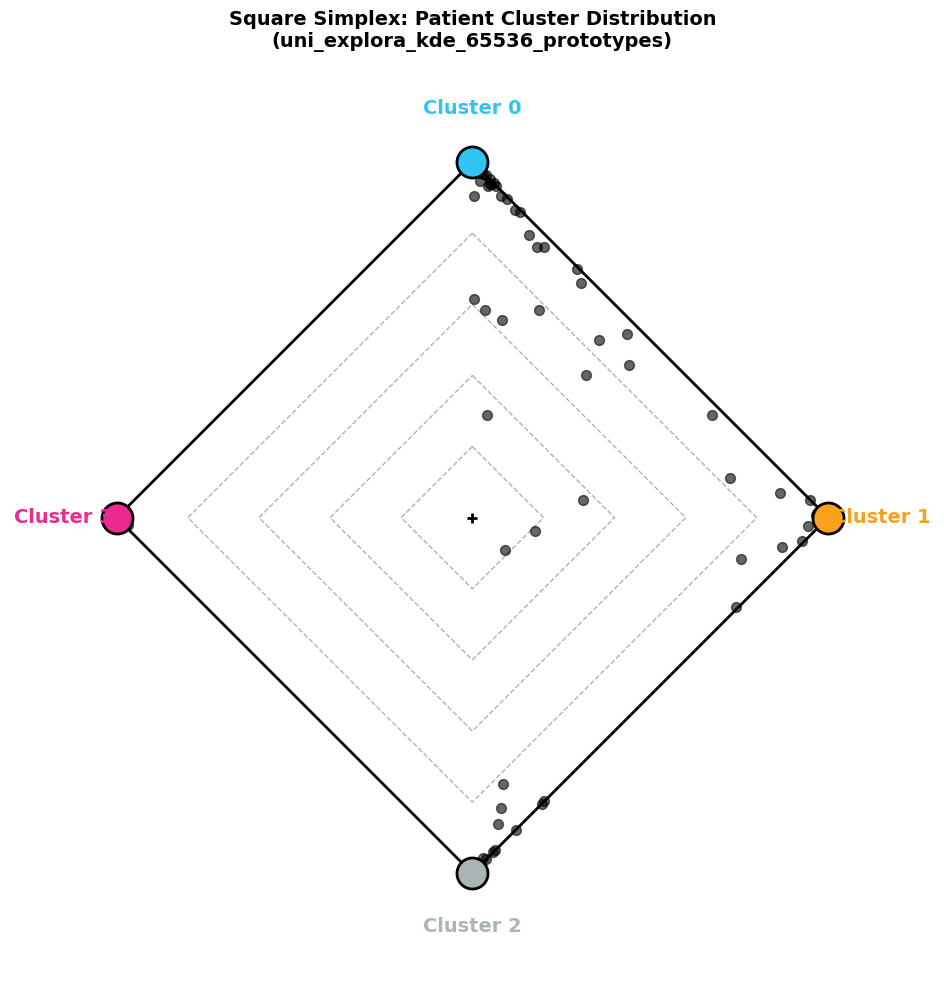


Model: uni_full_kde_4096_prototypes
Number of patients: 66
Number of clusters: 4


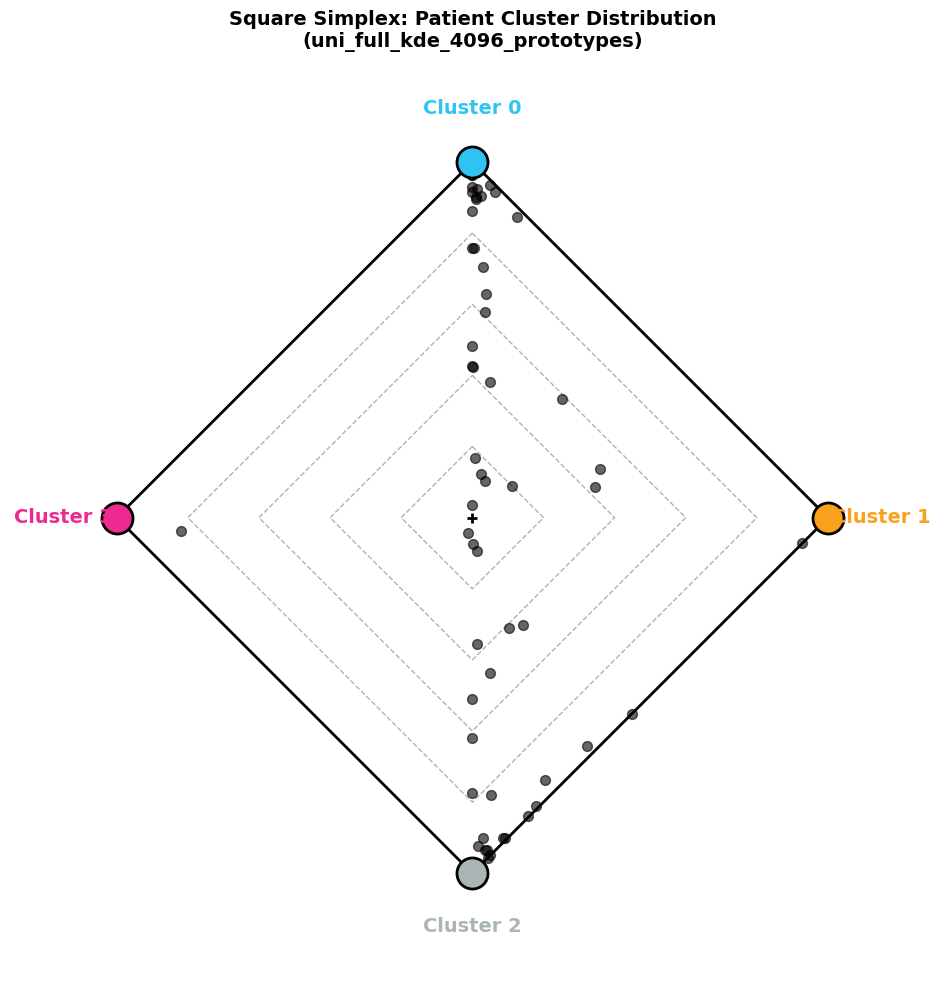


Model: uni_full_kde_16384_prototypes
Number of patients: 65
Number of clusters: 6


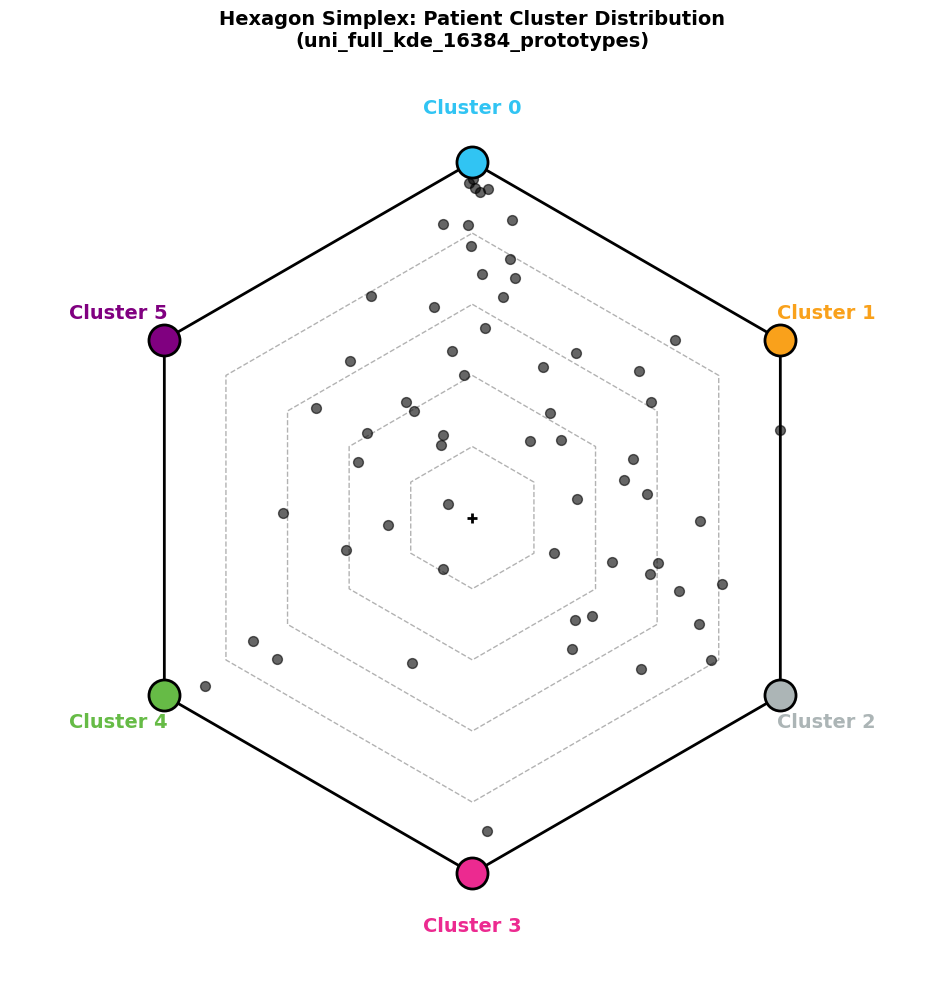


Model: uni_full_kde_65536_prototypes
Number of patients: 66
Number of clusters: 4


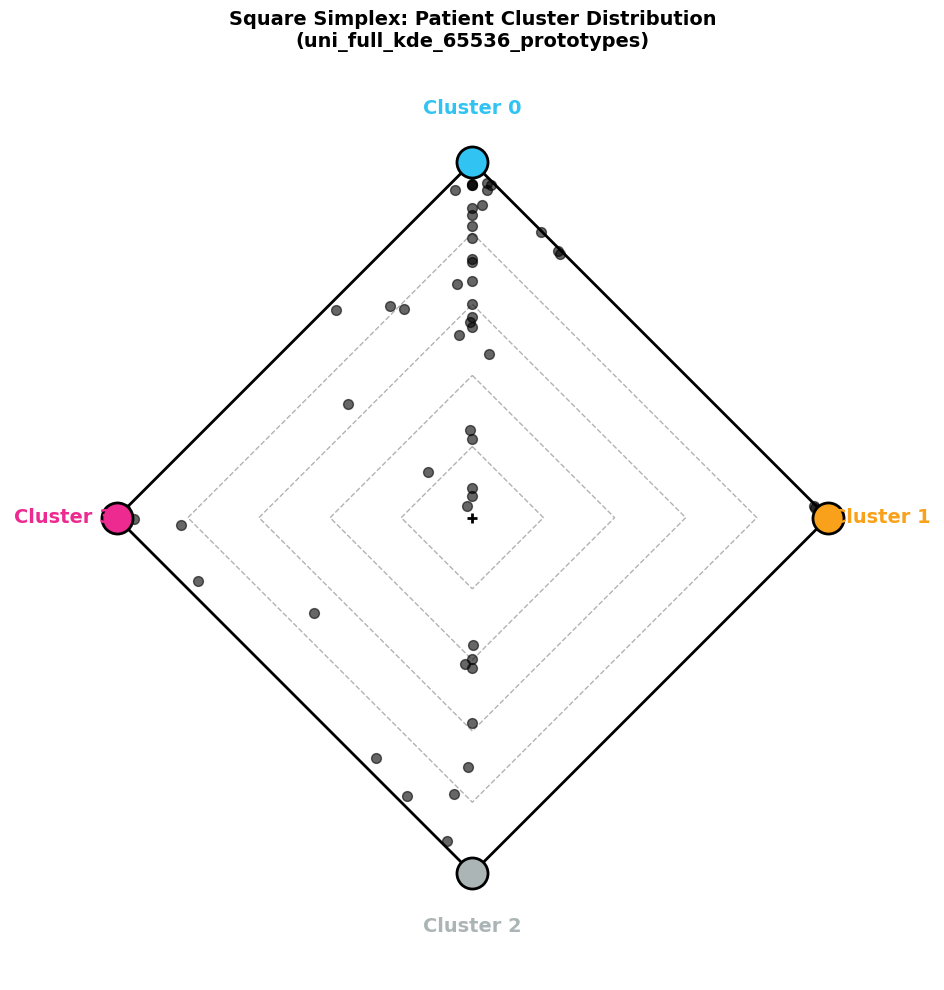


Model: uni_explora_koleo_4096_prototypes
Number of patients: 70
Number of clusters: 4


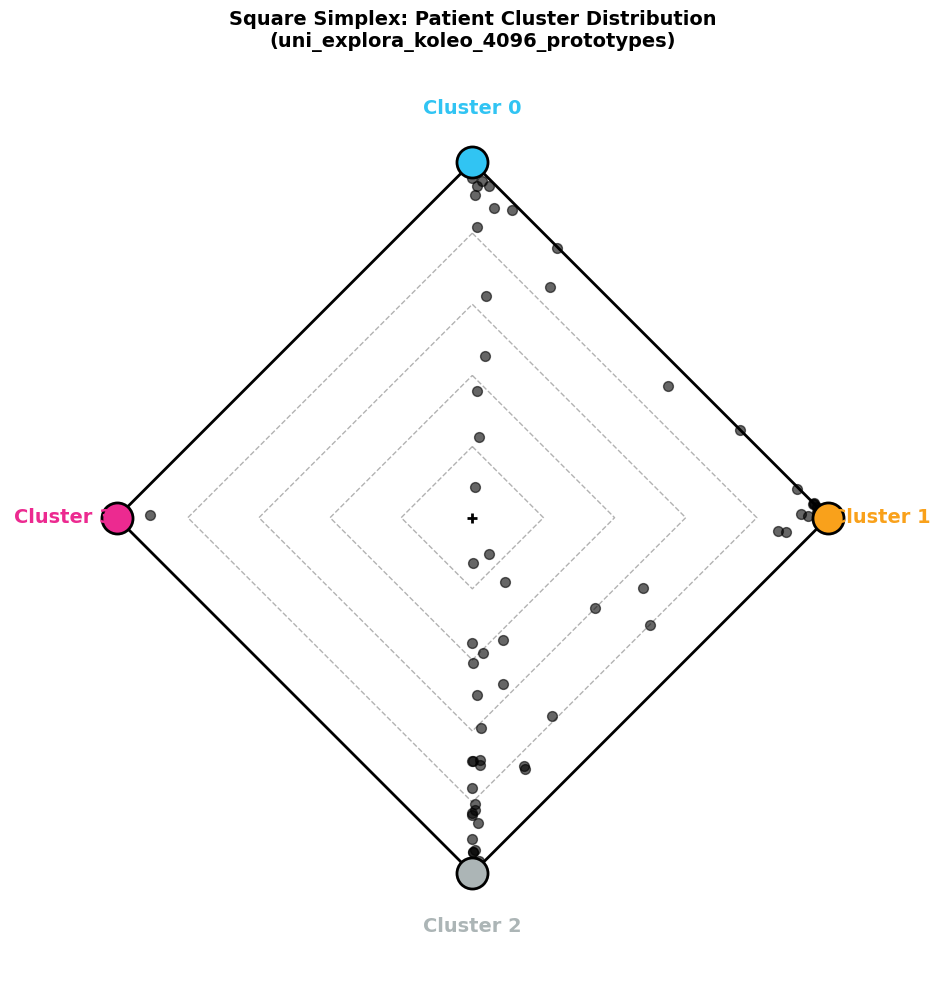


Model: uni_explora_koleo_16384_prototypes
Number of patients: 71
Number of clusters: 4


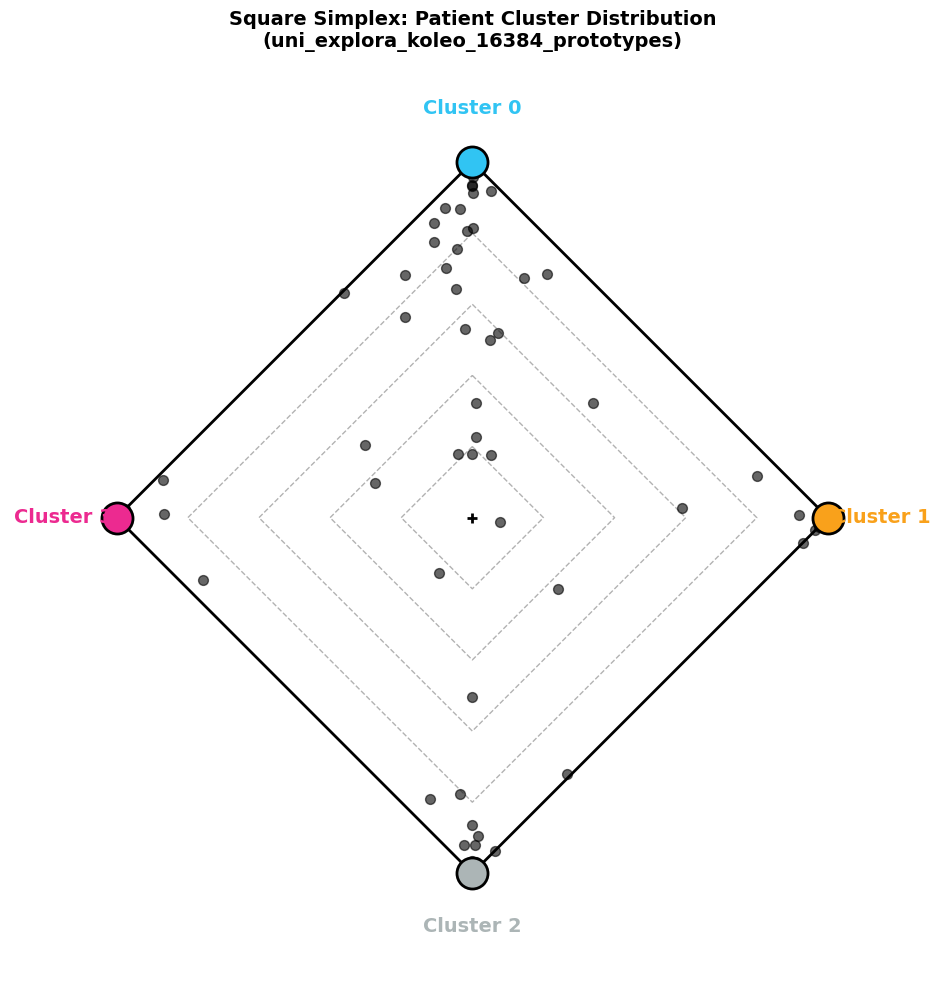


Model: uni_explora_koleo_65536_prototypes
Number of patients: 69
Number of clusters: 6


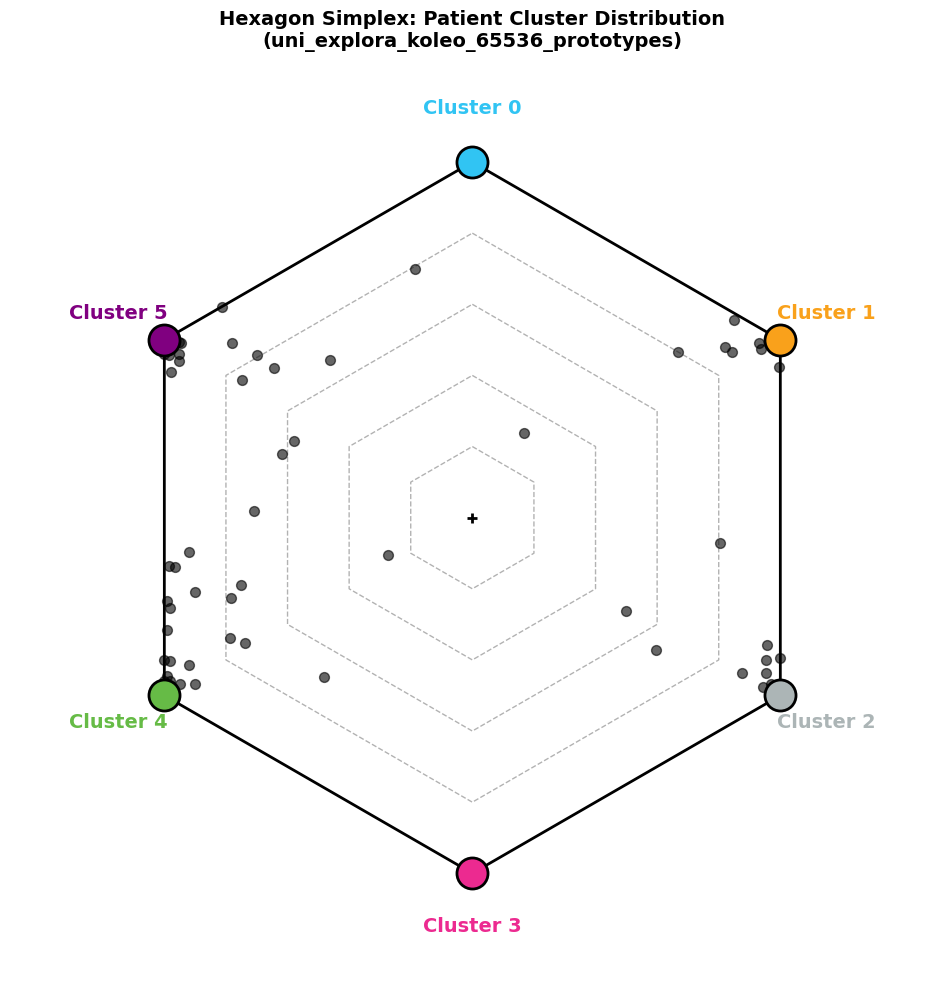


Model: uni_full_koleo_4096_prototypes
Number of patients: 62
Number of clusters: 6


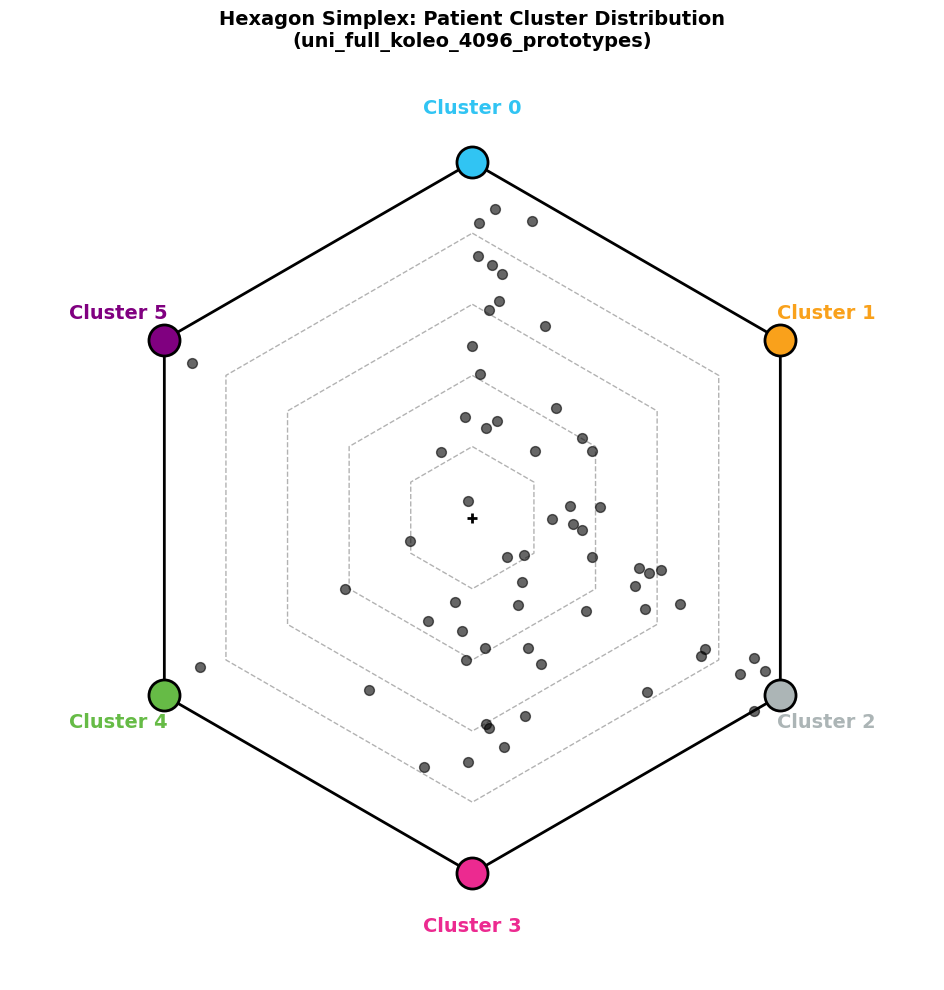


Model: uni_full_koleo_16384_prototypes
Number of patients: 63
Number of clusters: 6


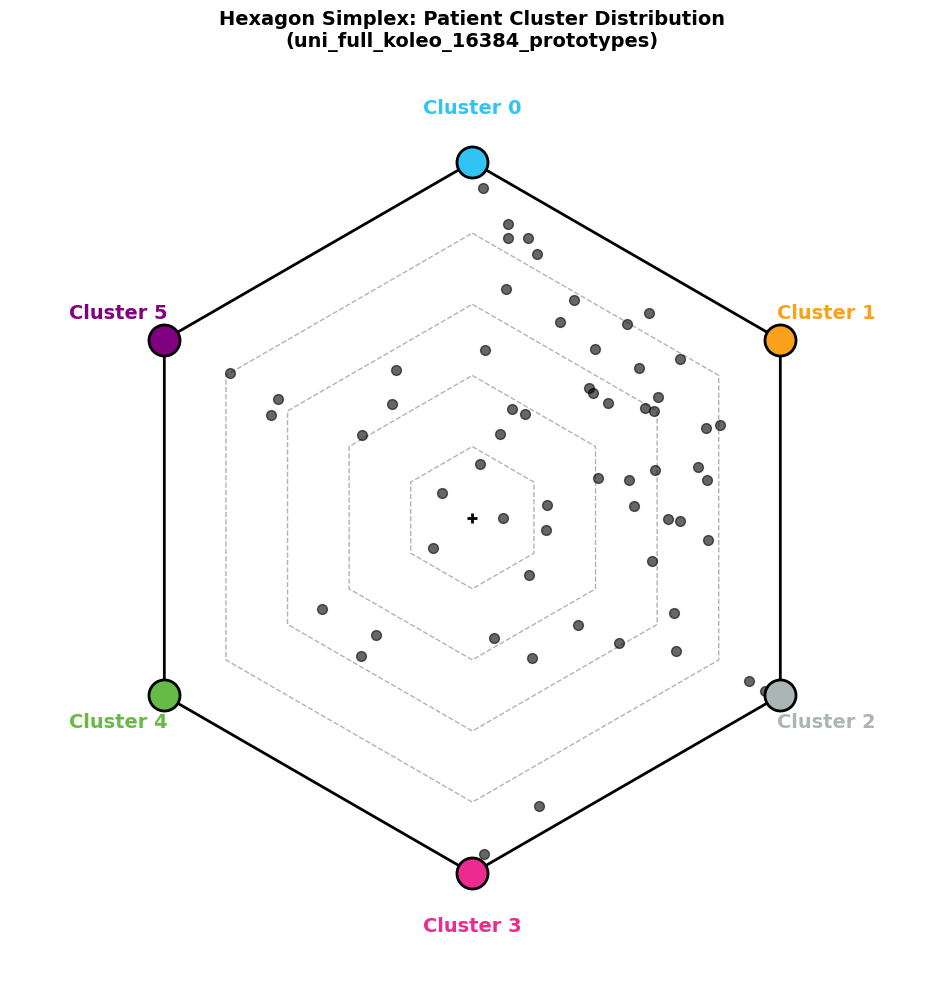


Model: uni_full_koleo_65536_prototypes
Number of patients: 63
Number of clusters: 5


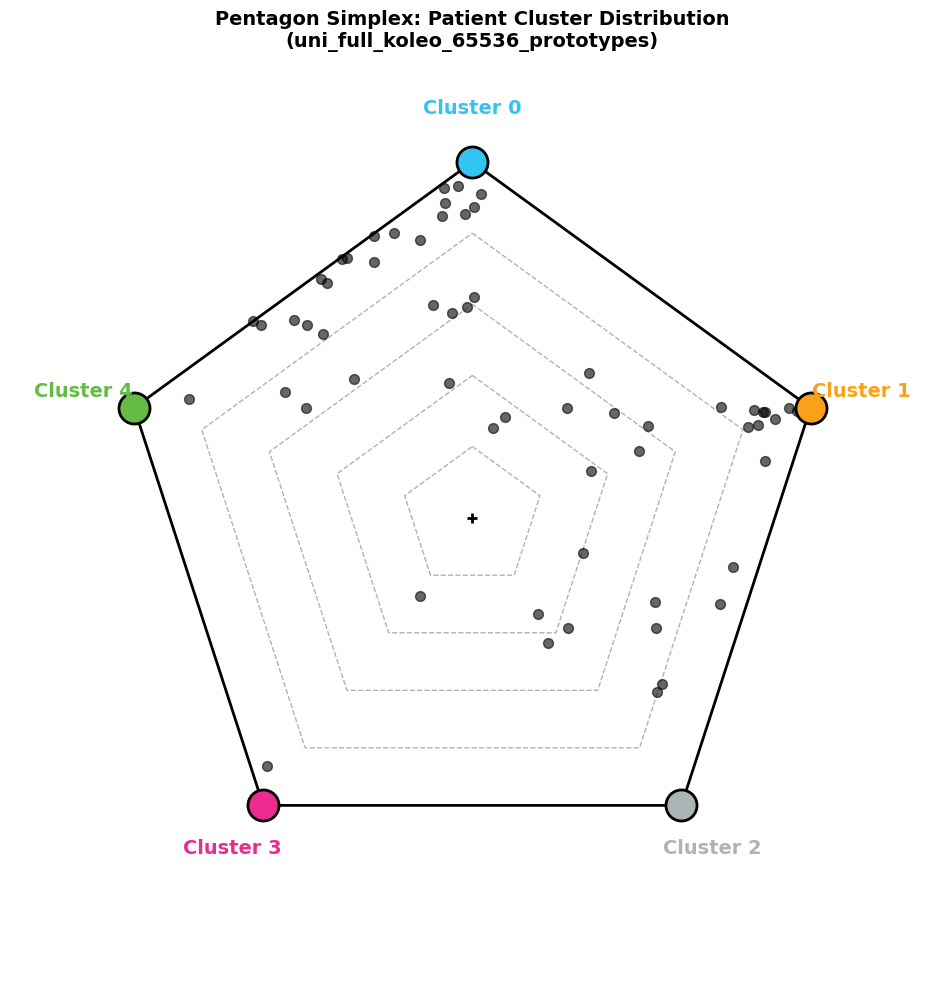

In [8]:
palette={'0': '#31C4F3', '2': '#ACB5B6', '4': '#66BB46', '3': '#EC2A90', '1': '#F9A11B', '5': 'purple', 'not invasive': 'white'}

# Create simplex plots for all models
all_coords = {}

for model_name in cluster_repartition_df['model'].unique():
    coords = create_simplex_plot(model_name, cluster_repartition_df, palette)
    if coords is not None:
        all_coords[model_name] = coords

In [9]:
# Check base models
patient_cluster_stats = []
base_names = ["uni", "provgigapath", "uni2"]
cluster_opti = {"uni": 5, "provgigapath": 5, "uni2": 6}
model_type = "base"
benchmark_path = config['base_benchmark_folder']
invasive_path = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)

for name in base_names:
    if name == "uni" and benchmark_path == config['retrained_benchmark_folder2']:
        continue
    
    filename = glob.glob(os.path.join(invasive_path, name, f"invasive_labels_{cluster_opti[name]}_clusters_umap_min_dist*"))[0]
    df = pd.read_csv(filename, index_col=0)
    df["patient"] = df.index.str.split("_").str[0]
    df["type"] = ["spot" if "spot" in idx else "patch" for idx in df.index]
    patient_with_low_invasive_cancer = df.value_counts("patient")[df.value_counts("patient") < 100].index.tolist()
    df = df[~df["patient"].isin(patient_with_low_invasive_cancer)]
    df = df[df["type"] == "spot"]

    n_global_clusters = df["predicted_label"].nunique()
    if n_global_clusters == 0:
        raise ValueError("No predicted_label values found in the dataframe after filtering.")

    for patient, group in df.groupby("patient"):
        cluster_counts = group["predicted_label"].value_counts()
        cluster_prop = cluster_counts/cluster_counts.sum()
        cluster_prop_dict = {k: v for k, v in zip(cluster_prop.index, cluster_prop.values)}
        for i in range(n_global_clusters):
            if i not in cluster_prop_dict.keys():
                cluster_prop_dict[i] = 0

        cluster_prop_dict = dict(sorted(cluster_prop_dict.items()))
        diversity_score = normalized_cluster_entropy(cluster_counts, n_global_clusters)
        patient_cluster_stats.append({
            "patient": patient,
            "cluster_diversity_score": diversity_score,
            "n_clusters_present": int(cluster_counts.size),
            "dominant_cluster": cluster_counts.idxmax(),
            "model": name,
            "proportions": cluster_prop_dict
        })

cluster_repartition_df_base = pd.DataFrame(patient_cluster_stats).sort_values("cluster_diversity_score", ascending=False)

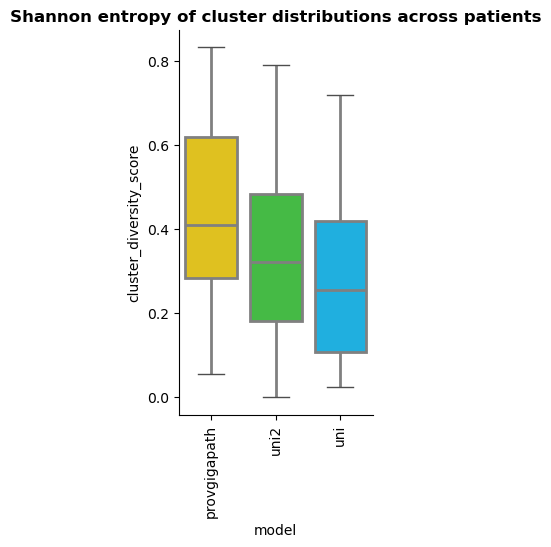

In [10]:
plt.figure(figsize=(2.5, 5))

sns.boxplot(
    data=cluster_repartition_df_base, y="cluster_diversity_score", x='model', hue="model",
    palette=config['base_model_palette'],  boxprops=dict(edgecolor='gray', linewidth=2), 
    medianprops=dict(color='gray', linewidth=2), whiskerprops=dict(color='gray', linewidth=2))

plt.xticks(rotation=90)
sns.despine()
plt.title("Shannon entropy of cluster distributions across patients", weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"cluster_diversity_in_base_models.pdf"), bbox_inches='tight')

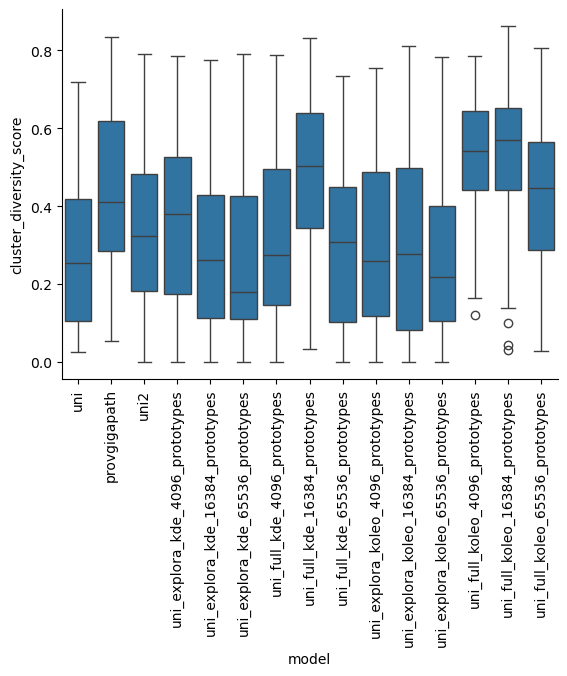

In [11]:
# Keep UNI only from base models
cluster_repartition_df_all = pd.concat([cluster_repartition_df_base, cluster_repartition_df[cluster_repartition_df['model'] != 'uni']])
order = base_names + sorted_retrained_models[1:]  

sns.boxplot(cluster_repartition_df_all, y="cluster_diversity_score", x='model', order=order)
plt.xticks(rotation=90)
sns.despine()
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"cluster_diversity_all_models_together.pdf"), bbox_inches='tight')

Mann-Whitney U statistic: 751.0
P-value: 1.5938005550188337e-10


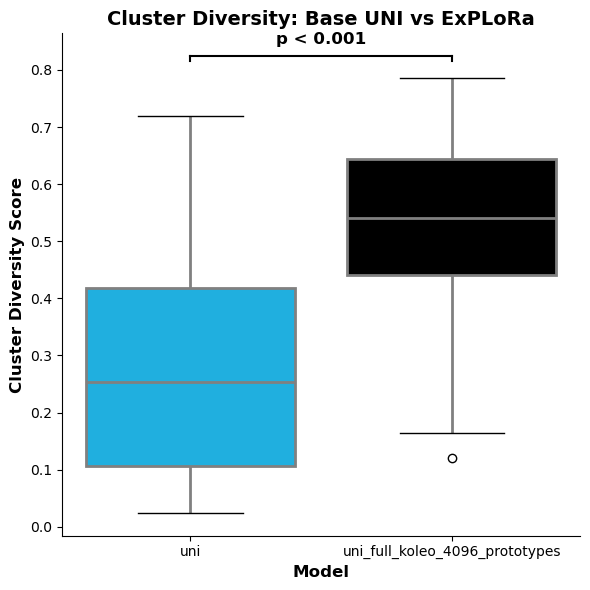

In [12]:
# Filter data for the two models
df_uni = cluster_repartition_df_all[cluster_repartition_df_all['model'] == 'uni']
df_explora = cluster_repartition_df_all[cluster_repartition_df_all['model'] == 'uni_full_koleo_4096_prototypes']
df_comparison = pd.concat([df_uni, df_explora])

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(
    df_uni['cluster_diversity_score'], df_explora['cluster_diversity_score'], alternative='two-sided')
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Create boxplot
fig, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(
    data=df_comparison, x='model', y='cluster_diversity_score', hue="model",
    palette={'uni': 'deepskyblue', 'uni_full_koleo_4096_prototypes': 'black'},
    boxprops=dict(edgecolor='gray', linewidth=2), medianprops=dict(color='gray', linewidth=2),
    whiskerprops=dict(color='gray', linewidth=2), ax=ax)

# Add p-value annotation
y_max = df_comparison['cluster_diversity_score'].max()
y_range = df_comparison['cluster_diversity_score'].max() - df_comparison['cluster_diversity_score'].min()
y_pos = y_max + 0.05 * y_range

# Draw significance bar
x1, x2 = 0, 1
ax.plot([x1, x2], [y_pos, y_pos], 'k-', linewidth=1.5)
ax.plot([x1, x1], [y_pos - 0.01 * y_range, y_pos], 'k-', linewidth=1.5)
ax.plot([x2, x2], [y_pos - 0.01 * y_range, y_pos], 'k-', linewidth=1.5)

# Add p-value text
if p_value < 0.001:
    p_text = f'p < 0.001'
elif p_value < 0.01:
    p_text = f'p < 0.01'
elif p_value < 0.05:
    p_text = f'p < 0.05'
else:
    p_text = f'p = {p_value:.3f}'

ax.text(
    (x1 + x2) / 2, y_pos + 0.02 * y_range, p_text, ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Cluster Diversity Score', fontsize=12, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.title('Cluster Diversity: Base UNI vs ExPLoRa', fontsize=14, fontweight='bold')
sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(config['figures_folder'], "Figure4",  f"cluster_diversity_uni_vs_explora_mannwhitney.pdf"), bbox_inches='tight')